In [1]:
import time
start_time = time.time()
import os
import numpy as np
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras import backend as K
from keras.optimizers import adam
from keras import models
import cv2
import dlib
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time 
import progressbar
from tqdm.notebook import tqdm_notebook

Using TensorFlow backend.


In [2]:
from sklearn import svm, datasets
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score

In [3]:
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
df = pd.read_csv('../Dataset_original_AMLS_19-20/cartoon_set/labels.csv', sep = '\t')
df = df.drop(columns = [df.columns[0]]).drop(columns = [df.columns[1]])
df['face_shape'] = df['face_shape'].apply(str)
df

,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png
...,...,...
9995,2,9995.png
9996,3,9996.png
9997,2,9997.png
9998,2,9998.png


In [5]:
img = ('../Dataset_original_AMLS_19-20/cartoon_set/img')
# training, testing = train_test_split(df, random_state=0)
training, validating = np.split(df.sample(frac=1), [int(0.9*len(df)),]) #splitting at n-array
print(training, validating)

     face_shape file_name
7035          2  7035.png
6759          3  6759.png
1262          4  1262.png
188           3   188.png
2647          0  2647.png
...         ...       ...
6601          3  6601.png
733           4   733.png
125           0   125.png
3211          3  3211.png
4532          4  4532.png

[9000 rows x 2 columns]      face_shape file_name
3858          4  3858.png
1576          1  1576.png
8391          4  8391.png
764           1   764.png
6713          4  6713.png
...         ...       ...
4500          0  4500.png
3623          4  3623.png
2109          0  2109.png
4531          1  4531.png
5317          3  5317.png

[1000 rows x 2 columns]


In [6]:
# set up data generator
data_generator = ImageDataGenerator(
    rescale = 1./255.,
    validation_split = 0.2,
    horizontal_flip=True,
    vertical_flip=True   
)

# # get batches of training images from the df
# train_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# validate_generator = data_generator.flow_from_dataframe(
#         dataframe=train_set,
#         x_col="file_name",
#         y_col="face_shape",
#         target_size=(178, 218),
#         batch_size=12,
#         class_mode='categorical')

# Get batches of training dataset from the dataframe
print("Training Dataset Preparation: ")
train_generator = data_generator.flow_from_dataframe(
        dataframe = training, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (32,32),
        batch_size = 128, subset = 'training') 
   
# Get batches of validation dataset from the dataframe
print("\nValidation Dataset Preparation: ")
validation_generator = data_generator.flow_from_dataframe(
        dataframe = validating, directory = img ,
        x_col = "file_name", y_col = "face_shape",
        class_mode = 'categorical', target_size = (32,32),
        batch_size = 128, subset = 'training')

Training Dataset Preparation: 
Found 7200 validated image filenames belonging to 5 classes.

Validation Dataset Preparation: 
Found 800 validated image filenames belonging to 5 classes.


In [64]:
# starting point 
my_model= models.Sequential()

# my_model.add(Dropout(0.2, input_shape=(64,64,3))) #height, width, depth
# Add first convolutional block
my_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(32,32,3) )) 
my_model.add(MaxPooling2D((2, 2), padding='same'))
# second block
my_model.add(Conv2D(32, (3, 3), activation='relu', padding='same')) #Convolution: filters, kernel_size that specifies the height and width of the 2D convolution window, p padding layers so dimensions of input = output
my_model.add(MaxPooling2D((2, 2), padding='same'))
# third block
my_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))
# fourth block
my_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
my_model.add(MaxPooling2D((2, 2), padding='same'))

# make predictions
my_model.add(Flatten())
my_model.add(Dense(5, activation='softmax'))
# Show a summary of the model. Check the number of trainable parameters
my_model.summary()
# compile model 
my_model.compile(optimizer='adam', loss='categorical_crossentropy', 
                 metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 4, 4, 128)        

In [65]:
# # use early stopping to optimally terminate training through callbacks

# es=EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# # save best model automatically
# mc= ModelCheckpoint('../dataset/cartoon_set', monitor='val_loss', 
#                     mode='min', verbose=1, save_best_only=True)
# cb_list=[es,mc]

In [66]:
# batch_size = 32
history = my_model.fit_generator(
                                train_generator,
                                epochs=18,
                                steps_per_epoch=train_generator.samples // train_generator.batch_size, 
                                #7200 samples, 225 batches, each with 32 samples, 5625 batches in total for epoch of 25
                                validation_data=validation_generator,
                                validation_steps=validation_generator.samples // validation_generator.batch_size
                                )

Epoch 1/18
56/56 [==============================] - 62s 1s/step - loss: 1.6049 - accuracy: 0.2344 - val_loss: 1.5896 - val_accuracy: 0.3333
Epoch 2/18
56/56 [==============================] - 69s 1s/step - loss: 1.4122 - accuracy: 0.3726 - val_loss: 1.2515 - val_accuracy: 0.4851
Epoch 3/18
56/56 [==============================] - 65s 1s/step - loss: 1.1425 - accuracy: 0.4918 - val_loss: 0.9631 - val_accuracy: 0.5432
Epoch 4/18
56/56 [==============================] - 62s 1s/step - loss: 0.9211 - accuracy: 0.6175 - val_loss: 0.8124 - val_accuracy: 0.6146
Epoch 5/18
56/56 [==============================] - 61s 1s/step - loss: 0.7262 - accuracy: 0.7070 - val_loss: 0.5592 - val_accuracy: 0.7664
Epoch 6/18
56/56 [==============================] - 61s 1s/step - loss: 0.5342 - accuracy: 0.8070 - val_loss: 0.5025 - val_accuracy: 0.8452
Epoch 7/18
56/56 [==============================] - 61s 1s/step - loss: 0.3879 - accuracy: 0.8590 - val_loss: 0.3330 - val_accuracy: 0.8497
Epoch 8/18
56/56 [==

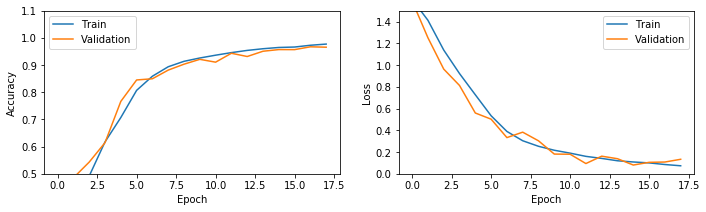

In [67]:
plt.figure(figsize=(18, 3))

plt.subplot(131)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([.5,1.1])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(132)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0,1.5])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')

plt.savefig("Custom_Keras_ODSC.png", dpi=300)

In [68]:
from keras.models import load_model

modelFile = 'my_CNN.h5'

# model_path = os.path.abspath(os.curdir)
# file_path = os.path.join(model_path, modelFile)
my_model.save(modelFile)

In [69]:
os.getcwd()

'C:\\Users\\User\\Desktop\\4th_year_AMLS\\AMLS_19-20_ChinYangTan_16053203\\Project_AMLS_19-20_16053203\\B1'

In [77]:
tr_sc = saved_model.evaluate_generator(train_generator, steps = validation_generator.samples // 32, verbose=1)

print('Train loss: '+ str(tr_sc[0]))
print('Train Accuracy: '+ str(tr_sc[1]))

25/25 [==============================] - 27s 1s/step
Train loss: 0.059739626944065094
Train Accuracy: 0.981249988079071


In [78]:
val_sc = saved_model.evaluate_generator(validation_generator, steps = validation_generator.samples // 32, verbose=1)

print('Validation loss: '+ str(val_sc[0]))
print('Validation Accuracy: '+ str(val_sc[1]))

25/25 [==============================] - 25s 993ms/step
Validation loss: 0.09753182530403137
Validation Accuracy: 0.9546703100204468


In [70]:
df2 = pd.read_csv('../Dataset_test_AMLS_19-20/cartoon_set_test/labels.csv', sep = '\t')
df2 = df2.drop(columns = [df2.columns[0]]).drop(columns = [df2.columns[1]])
df2['face_shape'] = df2['face_shape'].apply(str)
df2

,face_shape,file_name
0,1,0.png
1,4,1.png
2,2,2.png
3,2,3.png
4,3,4.png
...,...,...
2495,4,2495.png
2496,4,2496.png
2497,4,2497.png
2498,4,2498.png


In [71]:
img = ('../Dataset_test_AMLS_19-20/cartoon_set_test/img')

In [72]:
# saved_model = load_model(modelFile)
# test_generator = data_generator.flow_from_dataframe(
#         dataframe = testing, directory = img,
#         x_col = "file_name", y_col = "face_shape",
#         batch_size=1,
#         class_mode='categorical', target_size=(64, 64),
#         shuffle=False)
# test_steps = test_generator.samples
# print(test_steps)

saved_model = load_model(modelFile)
test_generator = data_generator.flow_from_dataframe(
        dataframe = df2, directory = img,
        x_col = "file_name", y_col = "face_shape",
        batch_size=1,
        class_mode='categorical', target_size=(32, 32),
        shuffle=False)
test_steps = test_generator.samples
print(test_steps)

Found 2500 validated image filenames belonging to 5 classes.
2500


In [73]:
test_generator.reset()
pred=saved_model.predict_generator(test_generator, verbose=1, steps=test_steps)
# determine the maximum activation value for each sample
predicted_class_indices=np.argmax(pred,axis=1)
# print(predicted_class_indices)
# label each predicted value to correct gender
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

# # format file names to simply male or female
# filenames=test_generator.filenames
# filenz=[0]
# for i in range(0,len(filenames)):
#     filenz.append(filenames[i].split('\\')[0])
# filenz=filenz[1:]

# # determine the test set accuracy
# match=[]
# for i in range(0,len(filenames)):
#     match.append(filenz[i]==predictions[i])
# match.count(True)/1000



2500/2500 [==============================] - 26s 10ms/step


In [74]:
import sklearn.metrics as metrics

[[461   2   0  33   4]
 [ 21 466   0   8   5]
 [  0   0 496   4   0]
 [  8   2   0 481   9]
 [  3   2   1  12 482]]

Confusion Matrix


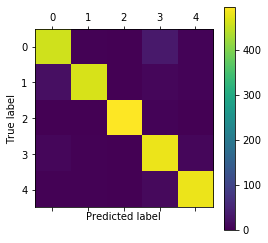

[[0.1844 0.0008 0.     0.0132 0.0016]
 [0.0084 0.1864 0.     0.0032 0.002 ]
 [0.     0.     0.1984 0.0016 0.    ]
 [0.0032 0.0008 0.     0.1924 0.0036]
 [0.0012 0.0008 0.0004 0.0048 0.1928]]

Confusion Matrix (normalised)


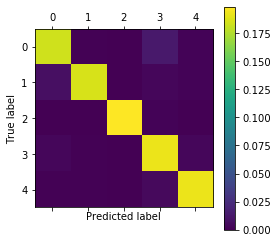

Classification report

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       500
           1       0.99      0.93      0.96       500
           2       1.00      0.99      0.99       500
           3       0.89      0.96      0.93       500
           4       0.96      0.96      0.96       500

    accuracy                           0.95      2500
   macro avg       0.96      0.95      0.95      2500
weighted avg       0.96      0.95      0.95      2500

Accuracy achieved: 0.9544 ♡♡♡


In [75]:
#confusion matrix and classification report

#Y_pred = my_model.predict_generator(test_generator, test_generator.samples // batch_size+1)
#y_pred = np.argmax(Y_pred, axis=1)


#target_names = ['0','1','2','3','4']
#print(classification_report(test_generator.classes, y_pred, target_names=target_names))

cm = confusion_matrix(test_generator.classes, predicted_class_indices)

print(cm)
plt.matshow(cm)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix')
plt.show()


cm2 = confusion_matrix(test_generator.classes, predicted_class_indices, normalize='all')

print(cm2)
plt.matshow(cm2)
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
print('\nConfusion Matrix (normalised)')
plt.show()

print('Classification report\n')
print(classification_report(test_generator.classes, predicted_class_indices))
print('Accuracy achieved:', accuracy_score(test_generator.classes, predicted_class_indices), '\u2661''\u2661''\u2661')

In [76]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 11054.621029376984 seconds ---
